#Abrir drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importar bibliotecas

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import datasets
from torchvision.models import mobilenetv2, MobileNet_V2_Weights
from torch.optim import lr_scheduler
from torch.utils.data import random_split

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path
import cv2
import random

In [ ]:
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.model_selection import train_test_split

# Definir seed

In [ ]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

#Preparação dos arquivos

## Abrir os arquivos

In [ ]:
!cp /content/drive/MyDrive/Upx_plantas/tomato_leafs_original.zip /content

In [ ]:
!unzip tomato_leafs_original.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: tomato_leafs_original/train/Tomato___Spider_mites Two-spotted_spider_mite/45530c9d-8c79-4436-8d2e-e4ba926d7ef3___Com-G_SpM_FL-8986_JPG.rf.637148d1bce99d81d737ebf54e6000b9.jpg  
  inflating: tomato_leafs_original/train/Tomato___Spider_mites Two-spotted_spider_mite/4558d92c-82e5-4a33-a0d2-0a61e743c767___Com-G_SpM_FL-1168_JPG.rf.77cffa9f9b888bb31189607ad9bfcc86.jpg  
  inflating: tomato_leafs_original/train/Tomato___Spider_mites Two-spotted_spider_mite/45973ec2-c906-4cc3-8b38-59a4ae2fb381___Com-G_SpM_FL-8653_JPG.rf.8e19fcfc9ea6929b74dc08afa7761dea.jpg  
  inflating: tomato_leafs_original/train/Tomato___Spider_mites Two-spotted_spider_mite/466043c2-30e9-4ac4-a8c7-89b56a43fbbb___Com-G_SpM_FL-1275_JPG.rf.b5cca36e6ac2d3aaa625324b6b591468.jpg  
  inflating: tomato_leafs_original/train/Tomato___Spider_mites Two-spotted_spider_mite/4681fec1-5bd9-49a5-975a-ca48bc826c22___Com-G_SpM_FL-1238_JPG.rf.383b77aaecf0a57909bda922724237

### Criação das classes (pastas)

# Criar rede CNN

## Configurar transformação par pré processamento das imagens

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.6, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

batch_size = 16

## Separar set de treino, teste e validação

In [ ]:
trainset = torchvision.datasets.ImageFolder(root='/content/tomato_leafs_original/train',
                                         transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, generator=g)

testset = torchvision.datasets.ImageFolder(root='/content/tomato_leafs_original/test',
                                        transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, generator=g)

validationset = torchvision.datasets.ImageFolder(root='/content/tomato_leafs_original/valid',
                                        transform=test_transforms)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, generator=g)

classes = ('Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot','Spider_mites Two-spotted_spider_mite',
           'Target_Spot','Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus',  'healthy',)

In [ ]:
validationset.classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

### Rede - Criada utilizando transfer learning

In [ ]:
cudnn.benchmark = True
plt.ion()

In [ ]:
class CNN(nn.Module):
  #arquitetura da rede
  def __init__(self, n_classes=10): # Torná-la parametrizável é uma boa prática
    super().__init__()
    self.model = mobilenetv2.mobilenet_v2(weights= MobileNet_V2_Weights.IMAGENET1K_V2)
    for param in self.model.parameters():
      param.requires_grad = False
    for param in list(self.model.features.parameters())[-20:]:
        param.requires_grad = True
    self.model = nn.Sequential(*list(self.model.children())[:-1])
    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(1280, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
      x = self.model(x)
      x = self.pool(x)
      x = torch.flatten(x, 1)

      x = F.relu(self.fc1(x))
      x = self.dropout(x)

      x = F.relu(self.fc2(x))
      x = self.dropout(x)

      x = self.fc4(x)
      return x

## Definindo a função de perda e otimizador

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
cnn = CNN().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 202MB/s]


In [ ]:
for param in list(cnn.model.parameters())[-20:]:
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## Treinando o modelo

In [ ]:
print("Número de classes no dataset:", len(trainset.classes))
print("Classes:", trainset.classes)


Número de classes no dataset: 10
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
def mixup_data(x, y, alpha=0.8):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
epochs = 50
best_score = float('inf')
early_stop = 5
counter = 0
save_path = "/content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt"

print(f"Iniciando treino com MIXUP (epochs={epochs}, early_stop={early_stop})...")
print(f"O melhor modelo será salvo em: {save_path}")

save_dir = os.path.dirname(save_path)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1}/{epochs} ---")
    print(f"Counter: {counter}/{early_stop} | Best Loss: {best_score:.6f}")

    # --- Treino com MIXUP ---
    cnn.train()
    train_loss = 0.0

    # --- A LINHA CRÍTICA (CORRIGIDA) ---
    # Certifique-se que o 'tqdm' está a "embrulhar" o 'train_loader'
    train = tqdm(trainloader, desc="Treinando (Mixup)")
    # O total de iterações deve ser ~1283, NÃO ~20516

    for data in train:
        inputs, labels = data
        # 'inputs' e 'labels' são AGORA TENSORS DE BATCH
        inputs, labels = inputs.to(device), labels.to(device) # Esta linha vai funcionar

        # --- APLICA O MIXUP ---
        mixed_inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()
        outputs = cnn(mixed_inputs)

        # --- CALCULA A PERDA DO MIXUP ---
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train.set_description('Train Loss: %.6f' % (loss.item()))

    # --- Validação (NÃO USA MIXUP) ---
    cnn.eval()
    validation_loss = 0.0

    # --- A LINHA CRÍTICA (CORRIGIDA) ---
    validation = tqdm(validationloader, desc="Validando")
    # O total de iterações deve ser ~211

    with torch.no_grad():
      for data in validation:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = cnn(inputs)
        loss = criterion(outputs, labels) # Loss normal aqui
        validation_loss += loss.item()
        validation.set_description('Val Loss: %.6f' % (loss.item()))

    # Calcular médias (pelo NÚMERO DE BATCHES, como o seu código original)
    validation_loss = validation_loss / len(validationloader)
    train_loss = train_loss / len(trainloader)

    print(f"Epoch Avg Train Loss: {train_loss:.6f}")
    print(f"Epoch Avg Val Loss:   {validation_loss:.6f}")

    # Lógica do Scheduler
    scheduler.step(validation_loss)

    # Lógica do Early Stopping
    if validation_loss < best_score - 1e-4:
        print(f"Val Loss melhorou! ({best_score:.6f} -> {validation_loss:.6f})")
        print(f"Salvando modelo em: {save_path}")
        torch.save(cnn.state_dict(), save_path)
        best_score = validation_loss
        counter = 0
    else:
        counter += 1
        print(f"Val Loss não melhorou. Counter: {counter}")

    if counter >= early_stop:
        print(f"Early stopping ativado na epoch {epoch+1}!")
        break

print(f'\nTreino Concluído. O melhor modelo (Mixup) está salvo em "{save_path}".')



Iniciando treino com MIXUP (epochs=50, early_stop=5)...
O melhor modelo será salvo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 1/50 ---
Counter: 0/5 | Best Loss: inf


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.840188
Epoch Avg Val Loss:   1.153461
Val Loss melhorou! (inf -> 1.153461)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 2/50 ---
Counter: 0/5 | Best Loss: 1.153461


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.499535
Epoch Avg Val Loss:   0.759707
Val Loss melhorou! (1.153461 -> 0.759707)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 3/50 ---
Counter: 0/5 | Best Loss: 0.759707


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.452801
Epoch Avg Val Loss:   0.869943
Val Loss não melhorou. Counter: 1

--- Epoch 4/50 ---
Counter: 1/5 | Best Loss: 0.759707


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.380578
Epoch Avg Val Loss:   0.656421
Val Loss melhorou! (0.759707 -> 0.656421)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 5/50 ---
Counter: 0/5 | Best Loss: 0.656421


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.348032
Epoch Avg Val Loss:   0.634463
Val Loss melhorou! (0.656421 -> 0.634463)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 6/50 ---
Counter: 0/5 | Best Loss: 0.634463


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.317541
Epoch Avg Val Loss:   0.505676
Val Loss melhorou! (0.634463 -> 0.505676)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 7/50 ---
Counter: 0/5 | Best Loss: 0.505676


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.281836
Epoch Avg Val Loss:   0.512574
Val Loss não melhorou. Counter: 1

--- Epoch 8/50 ---
Counter: 1/5 | Best Loss: 0.505676


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.298404
Epoch Avg Val Loss:   0.449939
Val Loss melhorou! (0.505676 -> 0.449939)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 9/50 ---
Counter: 0/5 | Best Loss: 0.449939


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.248879
Epoch Avg Val Loss:   0.675122
Val Loss não melhorou. Counter: 1

--- Epoch 10/50 ---
Counter: 1/5 | Best Loss: 0.449939


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.226286
Epoch Avg Val Loss:   0.447559
Val Loss melhorou! (0.449939 -> 0.447559)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 11/50 ---
Counter: 0/5 | Best Loss: 0.447559


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.229557
Epoch Avg Val Loss:   0.401221
Val Loss melhorou! (0.447559 -> 0.401221)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 12/50 ---
Counter: 0/5 | Best Loss: 0.401221


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.200496
Epoch Avg Val Loss:   0.565656
Val Loss não melhorou. Counter: 1

--- Epoch 13/50 ---
Counter: 1/5 | Best Loss: 0.401221


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.226009
Epoch Avg Val Loss:   0.453578
Val Loss não melhorou. Counter: 2

--- Epoch 14/50 ---
Counter: 2/5 | Best Loss: 0.401221


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.160732
Epoch Avg Val Loss:   0.423682
Val Loss não melhorou. Counter: 3

--- Epoch 15/50 ---
Counter: 3/5 | Best Loss: 0.401221


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.202447
Epoch Avg Val Loss:   0.385253
Val Loss melhorou! (0.401221 -> 0.385253)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 16/50 ---
Counter: 0/5 | Best Loss: 0.385253


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.196318
Epoch Avg Val Loss:   0.436633
Val Loss não melhorou. Counter: 1

--- Epoch 17/50 ---
Counter: 1/5 | Best Loss: 0.385253


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.150294
Epoch Avg Val Loss:   0.554160
Val Loss não melhorou. Counter: 2

--- Epoch 18/50 ---
Counter: 2/5 | Best Loss: 0.385253


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.193773
Epoch Avg Val Loss:   0.493929
Val Loss não melhorou. Counter: 3

--- Epoch 19/50 ---
Counter: 3/5 | Best Loss: 0.385253


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.181330
Epoch Avg Val Loss:   0.413101
Val Loss não melhorou. Counter: 4

--- Epoch 20/50 ---
Counter: 4/5 | Best Loss: 0.385253


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.109982
Epoch Avg Val Loss:   0.344024
Val Loss melhorou! (0.385253 -> 0.344024)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 21/50 ---
Counter: 0/5 | Best Loss: 0.344024


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.114240
Epoch Avg Val Loss:   0.430762
Val Loss não melhorou. Counter: 1

--- Epoch 22/50 ---
Counter: 1/5 | Best Loss: 0.344024


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.116485
Epoch Avg Val Loss:   0.402149
Val Loss não melhorou. Counter: 2

--- Epoch 23/50 ---
Counter: 2/5 | Best Loss: 0.344024


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.098739
Epoch Avg Val Loss:   0.354209
Val Loss não melhorou. Counter: 3

--- Epoch 24/50 ---
Counter: 3/5 | Best Loss: 0.344024


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.078797
Epoch Avg Val Loss:   0.395214
Val Loss não melhorou. Counter: 4

--- Epoch 25/50 ---
Counter: 4/5 | Best Loss: 0.344024


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.062116
Epoch Avg Val Loss:   0.335574
Val Loss melhorou! (0.344024 -> 0.335574)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 26/50 ---
Counter: 0/5 | Best Loss: 0.335574


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.077003
Epoch Avg Val Loss:   0.313737
Val Loss melhorou! (0.335574 -> 0.313737)
Salvando modelo em: /content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt

--- Epoch 27/50 ---
Counter: 0/5 | Best Loss: 0.313737


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.090775
Epoch Avg Val Loss:   0.365206
Val Loss não melhorou. Counter: 1

--- Epoch 28/50 ---
Counter: 1/5 | Best Loss: 0.313737


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.116388
Epoch Avg Val Loss:   0.349272
Val Loss não melhorou. Counter: 2

--- Epoch 29/50 ---
Counter: 2/5 | Best Loss: 0.313737


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.069376
Epoch Avg Val Loss:   0.369795
Val Loss não melhorou. Counter: 3

--- Epoch 30/50 ---
Counter: 3/5 | Best Loss: 0.313737


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.065636
Epoch Avg Val Loss:   0.372617
Val Loss não melhorou. Counter: 4

--- Epoch 31/50 ---
Counter: 4/5 | Best Loss: 0.313737


Treinando (Mixup):   0%|          | 0/493 [00:00<?, ?it/s]

Validando:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch Avg Train Loss: 1.074163
Epoch Avg Val Loss:   0.421719
Val Loss não melhorou. Counter: 5
Early stopping ativado na epoch 31!

Treino Concluído. O melhor modelo (Mixup) está salvo em "/content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt".


In [ ]:
print(labels)

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')


## Testar modelo

In [ ]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean  # desfaz a normalização
    return img.clamp(0, 1)  # garante valores válidos


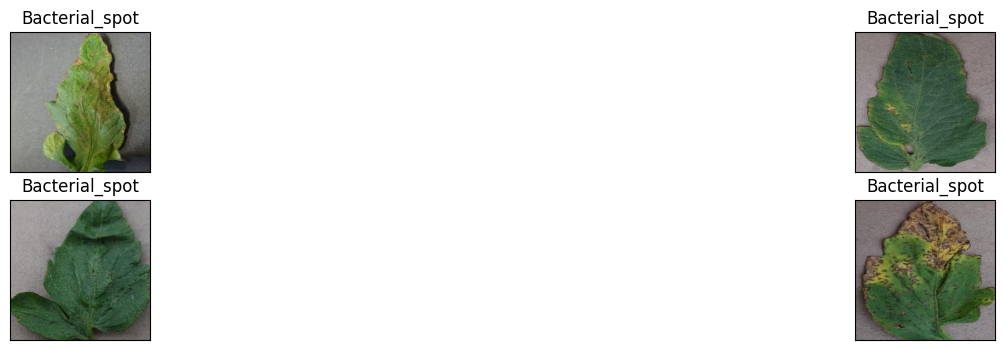

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 4//2, idx + 1, xticks=[], yticks=[])

    # desfaz normalização antes de mostrar
    img = denormalize(images[idx])
    img = img.numpy().transpose(1, 2, 0)

    plt.imshow(img)
    ax.set_title(classes[labels[idx]])

In [ ]:
images = images.to(device)
outputs = cnn(images)
outputs

_, predicted = torch.max(outputs, 1)
print("predicted: ", ' '.join('%5s'% classes[predicted[j]]
                             for j in range(4)))

predicted:  Bacterial_spot Bacterial_spot Bacterial_spot Bacterial_spot


## Performace total do modelo

In [ ]:
best_weights_path = "/content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt"

if os.path.exists(best_weights_path):
    print(f"Carregando os melhores pesos de '{best_weights_path}' para o teste...")
    # Carregar os pesos (map_location garante que funciona na CPU ou GPU)
    pesos = torch.load(best_weights_path, map_location=device)
    # Aplicar os pesos ao seu objeto 'cnn'
    cnn.load_state_dict(pesos)

Carregando os melhores pesos de '/content/drive/MyDrive/Upx_plantas/model/cnn_model_MIXUP.pt' para o teste...


In [ ]:
pred = []
labels_list = []
correct = 0
total = 0
cnn.eval()

with torch.no_grad():
  for data in testloader:
    images, label = data
    images = images.to(device)
    label = label.to(device)

    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)

    pred += predicted.cpu().tolist()
    labels_list += label.cpu().tolist()
    total += label.size(0)

    correct += (predicted == label).sum().item()

accuracy = correct / total
print(f'Accuracy no conjunto de teste: {accuracy:.4f}')

Accuracy no conjunto de teste: 0.9285


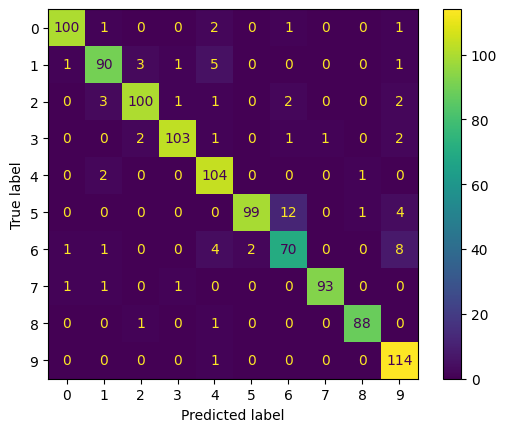

In [ ]:
cm = confusion_matrix(labels_list, pred)
ConfusionMatrixDisplay(cm).plot()